In [0]:
from google.colab import drive
drive.mount('/content/drive')

**Preprocessing**

We are converting the data i.e. the content of the xml files into a dictionary which will then be converted to a dataframe so that we could play with the data.

In [0]:
import glob
import os
from binascii import hexlify


path_a = '/content/drive/My Drive/xml_dataset/Class_A'
path_b = '/content/drive/My Drive/xml_dataset/Class_B'

dict = {'name': [],
        'label': []}

# Saving class A samples into the dictionary
for filename in glob.glob(os.path.join(path_a, '*.xml')):
    bin_data = open(filename, 'rb').read()
    # new = hexlify(bin_data)
    dict['name'].append(bin_data)
    dict['label'].append(0) 

print("done importing class a")


# Saving class B samples into the dictionary
for filename in glob.glob(os.path.join(path_b, '*.xml')):
    bin_data = open(filename, 'rb').read()
    # new = hexlify(bin_data)
    dict['name'].append(bin_data)
    dict['label'].append(1) 

print("done importing class b")

Conversion of the newly created dictionary to a dataframe to be saved in a csv file

In [0]:
import pandas as pd 

df = pd.DataFrame(dict) 
df.to_csv('/content/drive/My Drive/xml.csv')

**Starting the code**

Some necessary imports

In [0]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

Reading the csv file into a dataframe and checking if there exists any null values in the data

In [0]:
df = pd.read_csv('/content/drive/My Drive/xml.csv')
df = df[['name','label']]
df = df[pd.notnull(df['name'])]

In [0]:
df

Some visualization

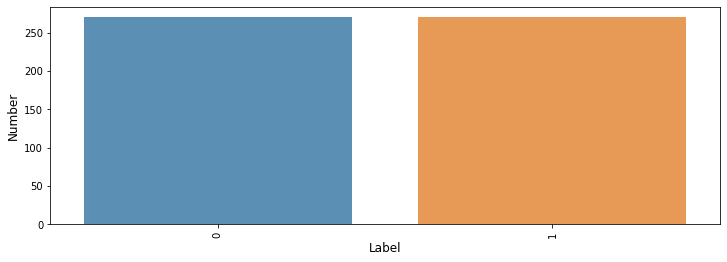

In [0]:
cnt_pro = df['label'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number', fontsize=12)
plt.xlabel('Label', fontsize=12)
plt.xticks(rotation=90)
plt.show();

Splitting the data into train and test sets (80/20)

In [0]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

We are tokenizing the content with [nltk tokenizer](https://www.nltk.org/api/nltk.tokenize.html)

In [0]:
import nltk
from nltk.corpus import stopwords

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [0]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Tagging every 'name' with its corresponding label

In [0]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['name']), tags=[r.label]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['name']), tags=[r.label]), axis=1)

There are two algorithms in doc2vec; Distributed Bag of Words (DBOW) & Distributed Memory (DM). We try both of them separately and then concatenate both of them in the end 

In [0]:
import multiprocessing

cores = multiprocessing.cpu_count()

***dm=0*** is used for DBOW, here the vectors are created by training a neural network which basically predicts the probability distribution of a portion of string taken from the document

***min_count = 2*** drops strings with frequency of occurence lower than 2

***workers = cores*** for parallel processing

***sample = 0*** used for downsampling

***vector_size = 300*** feature vectors

In [0]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 432/432 [00:00<00:00, 535918.17it/s]


Training for 30 epochs

In [0]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

Building the final vector for training

In [0]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [0]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

Training the classifier

In [0]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Now trying the second approach: DM. Rather than working on the occurences of strings, it remembers the context in which they are used.

In [0]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

In [0]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

In [0]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [0]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Freeing up some RAM (might be skipped)

In [0]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [0]:
!pip install testfixtures

     |████████████████████████████████| 92kB 2.8MB/s 


It is a know fact that combination of both DBOW and DM gives boost to the performance so we are concatenating both of them

In [0]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [0]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [0]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.9537037037037037
Testing F1 score: 0.95378740772628


**Saving the model**

In [0]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(logreg, open(filename, 'wb'))

**Testing the newly saved model**

In [0]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)

print(result)

0.9537037037037037


Testing a single sample

In [0]:
content = open('/content/drive/My Drive/other/204_b.xml', 'rb').read()

In [0]:
dict = {'name': [],
        'label': []}
dict['name'].append(str(content))
dict['label'].append(None)
content_df = pd.DataFrame(dict)

In [0]:
content_df = pd.DataFrame(dict)

In [0]:
content_df

In [0]:
content_tagged = content_df.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['name']), tags=[r.label]), axis=1)

In [0]:
_, sample = vec_for_learning(new_model, content_tagged)

In [0]:
prediction = loaded_model.predict(sample)

In [0]:
prediction